Train the entire neural network

Files already downloaded and verified
Files already downloaded and verified
Using cuda device
Initialising training ...
- Epochs: 15
- Mini batch size: 128
- Optimiser: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
- Loss function: cross_entropy
Epoch: 0 -- Loss: 728.5246704816818 -- Accuracy: 50
Epoch: 1 -- Loss: 461.25105208158493 -- Accuracy: 61
Epoch: 2 -- Loss: 352.842005610466 -- Accuracy: 69
Epoch: 3 -- Loss: 280.76765364408493 -- Accuracy: 71
Epoch: 4 -- Loss: 219.24986451864243 -- Accuracy: 76
Epoch: 5 -- Loss: 162.59780557453632 -- Accuracy: 76
Epoch: 6 -- Loss: 114.88210332393646 -- Accuracy: 79
Epoch: 7 -- Loss: 69.96016320586205 -- Accuracy: 77
Epoch: 8 -- Loss: 32.48177779838443 -- Accuracy: 81
Epoch: 9 -- Loss: 14.082105558365583 -- Accuracy: 83
Epoch: 10 -- Loss: 7.018824626691639 -- Accuracy: 82
Epoch: 11 -- Loss: 4.377614446915686 -- Accu

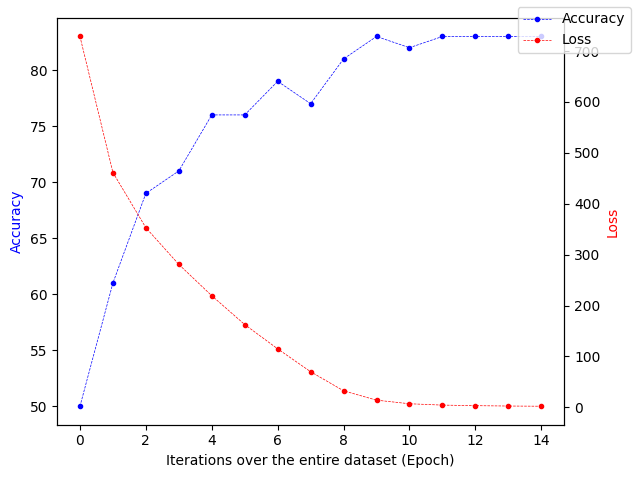

Testing on 10,000 test images ...
- Correct: 8352
- Total: 10000
- Accuracy: 83


83

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from nn_utils import Net, DEVICE, TRAINLOADER, train_nn, test_nn, freeze_parameters

torch.cuda.empty_cache()

# create a new neural network
torch.manual_seed(1)
net = Net()
net.to(DEVICE)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

train_nn(net=net, epochs=15, optimizer=optimizer)
test_nn(net=net, verbose=True)

Save the neural network model

In [2]:
PATH = './nn-models/cifar10-nn-model'
torch.save(net.state_dict(), PATH)

Load the pre-trained neural network model

In [3]:
PATH = './nn-models/cifar10-nn-model'

# load the pretrained NN model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device=DEVICE)

test_nn(net=net, verbose=True)

Testing on 10,000 test images ...
- Correct: 8352
- Total: 10000
- Accuracy: 83


83